In [1]:
import time
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import tensorflow as tf

## Chuẩn bị dữ liệu

In [2]:
import tensorflow as tf
import io
import numpy as np
import re

BOS = '<start>'
EOS = '<end>'
UTF_8 = 'UTF-8'

def preprocess_sentence(w, max_length):
    w = w.lower().strip()
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()

    # Truncate Length up to ideal_length
    w = " ".join(w.split()[:max_length+1])
    
    # Add start and end token 
    w = '{} {} {}'.format(BOS, w, EOS)
    # w = '{} {}'.format(w, EOS)
    return w

num_examples = 100000
num_examples_val = 1000
inp_lines = io.open('data/train/train.vi', encoding=UTF_8).read().strip().split('\n')[:num_examples]
targ_lines = io.open('data/train/train.en', encoding=UTF_8).read().strip().split('\n')[:num_examples]
inp_lines_val = io.open('data/validation/validation.vi', encoding=UTF_8).read().strip().split('\n')[:num_examples_val]
targ_lines_val = io.open('data/validation/validation.en', encoding=UTF_8).read().strip().split('\n')[:num_examples_val]

print(inp_lines[3])
print(targ_lines[3])
max_length = 100

inp_lines = [preprocess_sentence(inp, max_length) for inp in inp_lines]
targ_lines = [preprocess_sentence(targ, max_length) for targ in targ_lines]
inp_lines_val = [preprocess_sentence(inp, max_length) for inp in inp_lines_val]
targ_lines_val = [preprocess_sentence(targ, max_length) for targ in targ_lines_val]
    
print(inp_lines[3]) 
print(targ_lines[3])
print(inp_lines_val[3])
print(targ_lines_val[3])
# Tạo một đối tượng Tokenizer
inp_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' !"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
targ_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' !"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

# Xây dựng từ điển từ bộ dữ liệu
#inp_tokenizer.fit_on_texts(inp_lines + inp_lines_val)
#targ_tokenizer.fit_on_texts(targ_lines + targ_lines_val)

inp_tokenizer.fit_on_texts(inp_lines)
targ_tokenizer.fit_on_texts(targ_lines)
# Lấy từ điển từ và gán chỉ số từ
inp_to_index = inp_tokenizer.word_index
targ_to_index = targ_tokenizer.word_index

inp_tensor = inp_tokenizer.texts_to_sequences(inp_lines)
targ_tensor = targ_tokenizer.texts_to_sequences(targ_lines)
inp_val_tensor = inp_tokenizer.texts_to_sequences(inp_lines_val)
targ_val_tensor = targ_tokenizer.texts_to_sequences(targ_lines_val)

print(inp_tensor[3])
print(targ_tensor[3])

print(inp_val_tensor[3])
print(targ_val_tensor[3])

inp_tensor = tf.keras.preprocessing.sequence.pad_sequences(inp_tensor, padding='post', maxlen=max_length)
targ_tensor = tf.keras.preprocessing.sequence.pad_sequences(targ_tensor, padding='post', maxlen=max_length)
inp_val_tensor = tf.keras.preprocessing.sequence.pad_sequences(inp_val_tensor, padding='post', maxlen=max_length)
targ_val_tensor = tf.keras.preprocessing.sequence.pad_sequences(targ_val_tensor, padding='post', maxlen=max_length)

inp_tensor = tf.convert_to_tensor(inp_tensor, dtype=tf.int64)
targ_tensor = tf.convert_to_tensor(targ_tensor, dtype=tf.int64)
inp_val_tensor = tf.convert_to_tensor(inp_val_tensor, dtype=tf.int64)
targ_val_tensor = tf.convert_to_tensor(targ_val_tensor, dtype=tf.int64)


Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
<start> có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi . <end>
<start> headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog . <end>
<start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào , nhưng tôi vẫn nghĩ rằng mình sẽ sống cả cuộc đời ở bắctriều tiên , cho tới khi tất cả mọi thứ đột nhiên thay đổi . <end>
<start> although i often wondered about the outside world , i thought i would spend my entire life in north korea , until everything suddenly changed . <end>
[1, 7, 9, 781, 532, 33, 36, 20, 38, 533, 34, 299, 142

In [3]:
def texts_to_sequences(tokenizer, sentences):
    tar = []
    for word in sentences.split():
        if tokenizer.word_index.get(word) != None :
            tar.append(tokenizer.word_index.get(word))
    return tar

In [4]:
inp = texts_to_sequences(inp_tokenizer, inp_lines[3])
inp = tf.convert_to_tensor(inp, dtype=tf.int64)
inp

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([   1,    7,    9,  781,  532,   33,   36,   20,   38,  533,   34,
        299,  142,  380,  687,    3,   33,   36,   20,   38,   39,   34,
        259,  193,   11,  380,  103, 1737, 1655,    2], dtype=int64)>

In [5]:
# Định nghĩa hyperparameters
batch_size = 30
buffer_size = 8

# Tạo dataset từ inp_tensor và targ_tensor
dataset = tf.data.Dataset.from_tensor_slices((inp_tensor, targ_tensor))

# Pha trộn và phân lô dữ liệu
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

# Đặt kiểu dữ liệu của batch
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.int64), tf.cast(y, tf.int64)))

# Đặt prefetch để tải dữ liệu mẫu tiếp theo trong quá trình huấn luyện
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [6]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(30, 100), dtype=tf.int64, name=None), TensorSpec(shape=(30, 100), dtype=tf.int64, name=None))>

In [7]:
# Tạo dataset từ inp_tensor và targ_tensor
val_dataset = tf.data.Dataset.from_tensor_slices((inp_val_tensor, targ_val_tensor))

# Pha trộn và phân lô dữ liệu
val_dataset = val_dataset.shuffle(buffer_size).batch(8, drop_remainder=True)

# Đặt kiểu dữ liệu của batch
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.int64), tf.cast(y, tf.int64)))

# Đặt prefetch để tải dữ liệu mẫu tiếp theo trong quá trình huấn luyện
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [8]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(8, 100), dtype=tf.int64, name=None), TensorSpec(shape=(8, 100), dtype=tf.int64, name=None))>

## Position Encoding

In [9]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [10]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # Sinusoid
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # Sinusoid
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


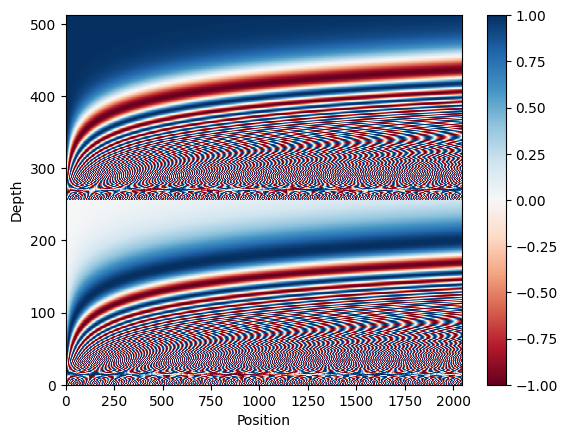

In [11]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Padding

In [12]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [13]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# Multi-Head Attention

In [14]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

# FFN

In [16]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder Layer

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

# Decoder Layer

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

# Encoder

In [19]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

# Decoder

In [20]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer

In [21]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [22]:
num_layers = 2
d_model = 128
dff = 128
num_heads = 16
dropout_rate = 0.1

# Optimizer

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [24]:
learning_rate = CustomSchedule(d_model, 8000)
    
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

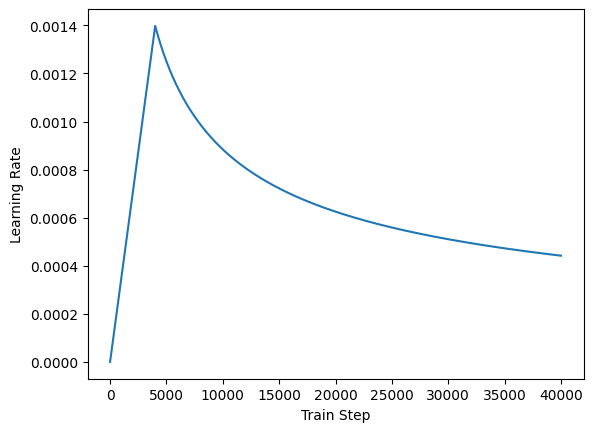

In [25]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss

In [26]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [27]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

# Model

In [29]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(inp_tokenizer.word_counts) + 1,
    target_vocab_size=len(targ_tokenizer.word_counts) + 1,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

## CheckPoint

In [30]:
checkpoint_path = "./checkpoints_vi_en_warmup/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

## Train

In [31]:
EPOCHS = 20

In [32]:
loss_history = []
accuracy_history = []
loss_val_history = []
accuracy_val_history = []
bleu_history = []

In [33]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [34]:
def calculate_bleu_scores(validation_dataset):
    smoother = SmoothingFunction().method1
    bleu_scores = []
    for (inp, tar) in validation_dataset:
        predictions, _ = transformer([inp, tar[:, :-1]], training=False)
        predictions = tf.argmax(predictions, axis=-1).numpy()
        for i in range(len(predictions)):
            pred_sentence = [targ_tokenizer.index_word[idx] for idx in predictions[i] if idx != 0]
            targ_sentence = [targ_tokenizer.index_word[idx] for idx in tar.numpy()[i, 1:] if idx != 0]
            bleu_score = nltk.translate.bleu_score.sentence_bleu([targ_sentence], pred_sentence, smoothing_function=smoother)
            bleu_scores.append(bleu_score)
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score

In [35]:
#@tf.function(input_signature=train_step_signature)
def validiate(val_dataset):
    val_loss.reset_states()
    val_accuracy.reset_states()
    for (batch, (inp, tar)) in enumerate(val_dataset):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        predictions, _ = transformer([inp, tar_inp], training=False)
        loss = loss_function(tar_real, predictions)

        val_loss(loss)
        val_accuracy(accuracy_function(tar_real, predictions))
    bleu = calculate_bleu_scores(val_dataset)
    return val_loss.result(), val_accuracy.result(), bleu

In [36]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) >= 1:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  loss_val, acc_val, bleu = validiate(val_dataset)
  
  loss_history.append(train_loss.result())
  accuracy_history.append(train_accuracy.result())
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)
  bleu_history.append(bleu)
  
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} - Accuracy {train_accuracy.result():.4f} \nValidation Loss {loss_val :.4f} - Validation Accuracy {acc_val :.4f} - BLEU {bleu :.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 10.5207 Accuracy 0.0000
Epoch 1 Batch 50 Loss 10.5099 Accuracy 0.0000
Epoch 1 Batch 100 Loss 10.4862 Accuracy 0.0006
Epoch 1 Batch 150 Loss 10.4444 Accuracy 0.0086
Epoch 1 Batch 200 Loss 10.3874 Accuracy 0.0174
Epoch 1 Batch 250 Loss 10.3130 Accuracy 0.0237
Epoch 1 Batch 300 Loss 10.2236 Accuracy 0.0279
Epoch 1 Batch 350 Loss 10.1183 Accuracy 0.0311
Epoch 1 Batch 400 Loss 9.9986 Accuracy 0.0333
Epoch 1 Batch 450 Loss 9.8642 Accuracy 0.0351
Epoch 1 Batch 500 Loss 9.7223 Accuracy 0.0368
Epoch 1 Batch 550 Loss 9.5661 Accuracy 0.0382
Epoch 1 Batch 600 Loss 9.4054 Accuracy 0.0397
Epoch 1 Batch 650 Loss 9.2447 Accuracy 0.0408
Epoch 1 Batch 700 Loss 9.0821 Accuracy 0.0419
Epoch 1 Batch 750 Loss 8.9284 Accuracy 0.0432
Epoch 1 Batch 800 Loss 8.7846 Accuracy 0.0438
Epoch 1 Batch 850 Loss 8.6543 Accuracy 0.0443
Epoch 1 Batch 900 Loss 8.5375 Accuracy 0.0447
Epoch 1 Batch 950 Loss 8.4392 Accuracy 0.0453
Epoch 1 Batch 1000 Loss 8.3315 Accuracy 0.0462
Epoch 1 Batch 1050 Loss 8.23

In [37]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2345216   
                                                                 
 decoder (Decoder)           multiple                  5055744   
                                                                 
 dense_32 (Dense)            multiple                  4760874   
                                                                 
Total params: 12,161,834
Trainable params: 12,161,834
Non-trainable params: 0
_________________________________________________________________


[6.496552, 4.7428265, 4.193665, 3.834221, 3.6265733, 3.561726, 3.535321, 3.4920356, 3.4454727, 3.4052193, 3.3696525, 3.34038, 3.3138256, 3.2906046, 3.2697384, 3.2482316, 3.2288854, 3.2105794, 3.1940572, 3.1788368]
[5.0016384, 4.1435866, 3.7645018, 3.5388541, 3.4320157, 3.4357817, 3.4088755, 3.3736386, 3.3573055, 3.3404238, 3.3235614, 3.3028219, 3.2906523, 3.290006, 3.2740083, 3.2797961, 3.2802207, 3.2738636, 3.293816, 3.2811434]
[0.13968234, 0.2952685, 0.35116413, 0.3890526, 0.4143062, 0.4313677, 0.44422042, 0.45433328, 0.46296442, 0.470086, 0.47658148, 0.48205915, 0.4867913, 0.4911287, 0.49472106, 0.49795216, 0.50132364, 0.50445706, 0.5074814, 0.50947267]
[0.2498, 0.3481, 0.3904, 0.4198, 0.4382, 0.4494, 0.4581, 0.4646, 0.4696, 0.473, 0.4744, 0.4771, 0.4783, 0.4784, 0.4799, 0.4791, 0.4795, 0.4817, 0.4794, 0.4819]
[0.006313251699187374, 0.0137596183327657, 0.018390622043679503, 0.02179937218990065, 0.024159099644785735, 0.025456951554308632, 0.027398618007556216, 0.02829618911122033, 0.

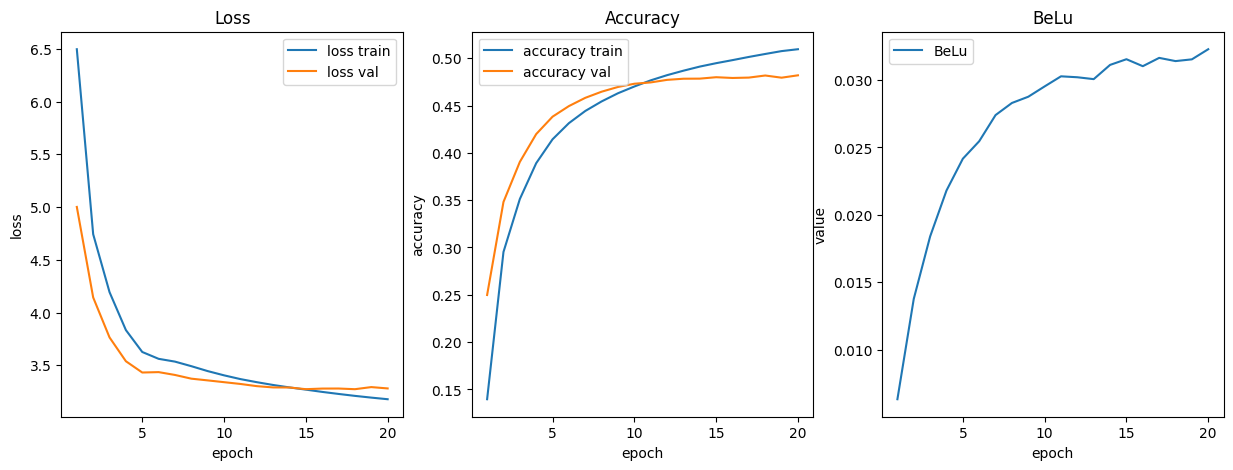

In [45]:
figre, axs = plt.subplots(1, 3, figsize = (15, 5))

loss_train = [loss.numpy() for loss in loss_history]
loss_val = [loss.numpy() for loss in loss_val_history]
acc_train = [acc.numpy() for acc in accuracy_history]
acc_val = [acc.numpy() for acc in accuracy_val_history]

print(loss_train)
print(loss_val)
print(acc_train)
print(acc_val)
print(bleu_history)

ep = list(range(1, EPOCHS + 1))

axs[0].plot(ep, loss_train, label = 'loss train')
axs[0].plot(ep, loss_val, label = 'loss val')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(ep, acc_train, label = 'accuracy train')
axs[1].plot(ep, acc_val, label = 'accuracy val')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

axs[2].plot(ep, bleu_history, label = 'BeLu')
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('value')
axs[2].set_title('BeLu')
axs[2].legend()

In [46]:
class Translator(tf.Module):
  def __init__(self, inp_tokenizer, targ_tokenizer, transformer):
    self.inp_tokenizer = inp_tokenizer
    self.targ_tokenizer = targ_tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=30):
   
    # assert isinstance(sentence, tf.Tensor)
    # if len(sentence.shape) == 0:
    #  sentence = sentence[tf.newaxis]
      
    # sentence = sentence.numpy().tolist()
    # sentence = ' '.join(sentence)
    sentence = texts_to_sequences(self.inp_tokenizer, sentence)
    # print(sentence)
    sentence = tf.convert_to_tensor(sentence, dtype=tf.int64)
    print(sentence)
    encoder_input = sentence
    # print(encoder_input)
    # if len(sentence.shape) == 0:
    #  sentence = sentence[tf.newaxis]
    encoder_input = tf.expand_dims(encoder_input, 0)

    
    start = targ_tokenizer.word_index.get(BOS)
    start = tf.cast(tf.expand_dims(start, 0), tf.int64)
    end = targ_tokenizer.word_index.get(EOS)
    # print(start)
    
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    print(output)
    # output.shape (1, tokens)
    # text = tokenizers.en.detokenize(output)[0]  # shape: ()

    # tokens = tokenizers.en.lookup(output)[0]

    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    output = tf.squeeze(output)
    output = output.numpy().tolist()
    
    text = ""
    for index in output:
      text += targ_tokenizer.index_word.get(int(index)) + " "
      
    return text, attention_weights

In [47]:
translator = Translator(inp_tokenizer, targ_tokenizer, transformer)

In [48]:
def print_translation(sentence, text, truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {text}')
  print(f'{"Truth":15s}: {truth}')

In [49]:
sentence = "Và tất cả các trang đều được xem xét bởi 400 khoa học gia và nhà phê bình khác từ 113 quốc gia ."
ground_truth = "And all of those pages were reviewed by another 400-plus scientists and reviewers , from 113 countries ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20))
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1    3   96   59   17  444  203   21  187  621   92 1601  323   64
  146    3   77 1111  266   67   49 7519    2], shape=(23,), dtype=int64)
tf.Tensor(
[[   1    4   35    3 1684   23  394   36 1488  788    4   93  788   45
     3    7   72  170    2]], shape=(1, 19), dtype=int64)
Input:         : Và tất cả các trang đều được xem xét bởi 400 khoa học gia và nhà phê bình khác từ 113 quốc gia .
Prediction     : <start> and all the pages are looked at 400 scientists and other scientists from the of their own <end> 
Truth          : And all of those pages were reviewed by another 400-plus scientists and reviewers , from 113 countries .


In [50]:
sentence = "Mô hình của chúng tôi gồm hàng trăm ngàn thùng xếp chồng tính toán với hàng trăm biến số trong thời gian cực ngắn"
ground_truth = "Our models have hundreds of thousands of grid boxes calculating hundreds of variables each , on minute timescales ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1  363   98   10    8    4  761  167  490  843 1562  839 1085  159
  472   23  167  490  299   78   16  124    2], shape=(23,), dtype=int64)
tf.Tensor(
[[   1   51  489 1146  698    7  518    7 2893 2711  698    7  698    7
   271   11   83    2]], shape=(1, 18), dtype=int64)
Input:         : Mô hình của chúng tôi gồm hàng trăm ngàn thùng xếp chồng tính toán với hàng trăm biến số trong thời gian cực ngắn
Prediction     : <start> our model including hundreds of thousands of boxes calculate hundreds of hundreds of times in time <end> 
Truth          : Our models have hundreds of thousands of grid boxes calculating hundreds of variables each , on minute timescales .


In [51]:
sentence = "Cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển ."
ground_truth = "They are both two branches of the same field of atmospheric science ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1   59  185  203    5    6 2153   10  120    6  786  433   16  617
  323   64  380  941    2], shape=(19,), dtype=int64)
tf.Tensor([[   1  386   23    8 5821    7   40    7    3  723    7  337    2]], shape=(1, 13), dtype=int64)
Input:         : Cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển .
Prediction     : <start> both are a branches of one of the field of science <end> 
Truth          : They are both two branches of the same field of atmospheric science .


In [52]:
sentence = "Chính vì lượng khí thải rất lớn , nó có ý nghĩa quan trọng với hệ thống khí quyển ."
ground_truth = "And because it &apos;s so much stuff , it &apos;s really important for the atmospheric system ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[  1  85  45 193 380 923  51 119  22   7 102 211  80 186  23 156 209 380
 941   2], shape=(20,), dtype=int64)
tf.Tensor(
[[   1   54    3  781 1119    7    3 1119   15   56  162   12  264    9
    12  264    9   12  264  184   28    3 1474    2]], shape=(1, 24), dtype=int64)
Input:         : Chính vì lượng khí thải rất lớn , nó có ý nghĩa quan trọng với hệ thống khí quyển .
Prediction     : <start> because the major waste of the waste is very big it means that it means that it means important with the atmosphere <end> 
Truth          : And because it &apos;s so much stuff , it &apos;s really important for the atmospheric system .


In [65]:
sentence = "Hôm nay tôi đi học"
ground_truth = "Today, I go to school"

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor([  1 428 214   4  75  64   2], shape=(7,), dtype=int64)
tf.Tensor([[  1 156  10  98   5 217   2]], shape=(1, 7), dtype=int64)
Input:         : Hôm nay tôi đi học
Prediction     : <start> today i go to school <end> 
Truth          : Today, I go to school


In [57]:
sentence = "Bắt chước những gì bạn nhìn thấy ."
ground_truth = "You can mimic what you can see ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor([   1  115 1582    9   50   12  113   54    2], shape=(9,), dtype=int64)
tf.Tensor([[ 1 18 25 37 13 69  2]], shape=(1, 7), dtype=int64)
Input:         : Bắt chước những gì bạn nhìn thấy .
Prediction     : <start> so what do you see <end> 
Truth          : You can mimic what you can see .


In [55]:
sentence = "Vì đó là lần đầu tiên tôi biết rằng đồng bào của tôi đang phải chịu đựng như vậy ."
ground_truth = "This was the first time I heard that people in my country were suffering ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1   45   14    5  208   58  202    4   70   48  191  374   10    4
   46   43  673 1203   33   65    2], shape=(21,), dtype=int64)
tf.Tensor(
[[   1   54   12    6   16    3  105   83   10   63    9   39  547   15
  1441    2]], shape=(1, 16), dtype=int64)
Input:         : Vì đó là lần đầu tiên tôi biết rằng đồng bào của tôi đang phải chịu đựng như vậy .
Prediction     : <start> because it apos s the first time i know that my cell is suffering <end> 
Truth          : This was the first time I heard that people in my country were suffering .


In [56]:
sentence = "Sáng sớm, tôi dậy và ngồi một lát để thư giãn. Tôi đứng dậy, mở cửa sổ và thấy ánh nắng mặt trời chiếu sáng qua cành cây. Tôi hít thở không khí trong lành và ngửi hương của hoa. Tiếng chim hót vang lên từ công viên gần đó. Tôi cảm nhận được sự yên bình và sự tươi mới của ngày mới. Tôi rất thích khoảnh khắc này và hy vọng ngày hôm nay sẽ tốt đẹp."
ground_truth = "In the early morning, I woke up and sat for a while to relax. I stood up, opened the window, and saw the sunlight shining through the tree branches. I took a deep breath of fresh air and smelled the fragrance of flowers. The sound of birds singing echoed from the nearby park. I felt the peace and freshness of the new day. I really enjoy this moment and hope that today will be beautiful."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=100), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1  200 1046    4  925    3  554    6 1653   32  493 1781    4  542
  925  410  605 1268    3   54  531 1777  169  482  727  200  133 3006
  474    4 2283 1135   11  380   16 1185    3 2438 1292   10  587  309
  856 3404 1880  128   49   62  220  293   14    4  101  104   21   24
 1213  266    3   24 1604  149   10  125  149    4   51  189 1095  686
   20    3  663  449  125  428  214   35  160  450    2], shape=(81,), dtype=int64)
tf.Tensor(
[[   1  556  692    4   10 1252    8  299   21    3    5   76   61    5
     3 1801    4   69    3  729  139    3  729   10    6   79  192    5
  2811  139    3  571   10    6   79  192    5 2811   11    3  422  366
     4    3  198   83   10    6   79  521    5  250   43   17  149    4
    10    6   79   62    5   33  192    5   33  192    5   33  192    5
    33  192    5   33  192    5   33  192    5  763  156    6   79   62
     5   33  192    5   33  192    5   33  192    5   33  192    5   33
   192    5   33  192    5   33  19